In [2]:
%matplotlib inline
import nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import os
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import gdal
import sqlite3
import numpy as np
import cartopy.feature as cfeature
import ipyparallel as ipp
import mpld3
import seaborn as sn
from cartopy import crs as ccrs
from sqlalchemy import create_engine
hv.notebook_extension()

In [3]:
# Filter warnings. Use in final version of notebook only
import warnings
warnings.filterwarnings('ignore')

# MARS climate data processing

This notebook documents processing of the MARS climate datasets for Jannicke and Jess. For a description of the processing required, see the e-mail from Jess received 29/01/2018 at 16.00.

## 1. Datasets

Jess is interested in daily average temperature (`'tas'`) and wind speed (`'wind'`) for five different climate models and two emissions scenarios (`'rcp4p5'` and `rcp8p5`). The original datasets are on the network here:

K:\Prosjekter\Ferskvann\MARS EU FP7_O-13198\WP4\2.6_Scenario\Scenario\CLIMATE

I've copied these locally and then put all the .nc files (for both wind and temperature) for each model-scenario combination into a single folder. Each scenario folder contains 188 .nc files (94 for temperature and 94 for wind). A useful feature of [xarray](http://xarray.pydata.org/en/stable/) is that it can create a "view" where all these files are combined into a single, multi-variable dataset.

## 2. Explore data

As a first step, I want to explore some of the climate data to see that it looks broadly sensible. The code below focuses on a single scenario and a single model.

In [3]:
# Read all the .nc files for GFDL-ESM2M, rcp4p5
nc_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
           r'\Jess_R_Climate_Processing\netCDF\GFDL-ESM2M\rcp4p5\*.nc')
ds = xr.open_mfdataset(nc_path)
ds

<xarray.Dataset>
Dimensions:     (lat: 110, lon: 110, time: 34333)
Coordinates:
  * lat         (lat) float32 89.75 89.25 88.75 88.25 87.75 87.25 86.75 ...
  * lon         (lon) float32 -9.75 -9.25 -8.75 -8.25 -7.75 -7.25 -6.75 ...
  * time        (time) datetime64[ns] 2006-01-01 2006-01-02 2006-01-03 ...
Data variables:
    projection  (time) |S1 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ...
    wgs84       (time) |S1 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ...
    wind        (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    tas         (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

Based on this, we have a 0.5 degree resolution lat-lon grid using WGS84 geographic co-ordinates. Each time slice is an array with 110 columns and 110 rows, and there are 34333 daily time slices in total, beginning on 01/01/2006. The two data variables of interest, `'tas'` and `'wind'`, are available, as expected.

To get a feel for this dataset, the code below creates interactive maps showing the average annual temperature and windspeed for just 5 years (from 2006 to 2010 inclusive). *Use the time-slide to the right of the plots to switch between years*.

In [4]:
# Get just the data from 2006 to 2010
ds2 = ds.loc[dict(time=slice('2006-01-01', '2010-12-31'))]

# Calculate annual averages along time axis
ds2 = ds2.resample('A', dim='time', how='mean')
ds2

<xarray.Dataset>
Dimensions:  (lat: 110, lon: 110, time: 5)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 87.75 87.25 86.75 86.25 ...
  * lon      (lon) float32 -9.75 -9.25 -8.75 -8.25 -7.75 -7.25 -6.75 -6.25 ...
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    wind     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    tas      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

:Layout
   .HoloMap.I  :HoloMap   [time]
      :Overlay
         .Image.I     :Image   [lon,lat]   (tas)
         .Coastline.I :Feature   [Longitude,Latitude]
   .HoloMap.II :HoloMap   [time]
      :Overlay
         .Image.I     :Image   [lon,lat]   (wind)
         .Coastline.I :Feature   [Longitude,Latitude]
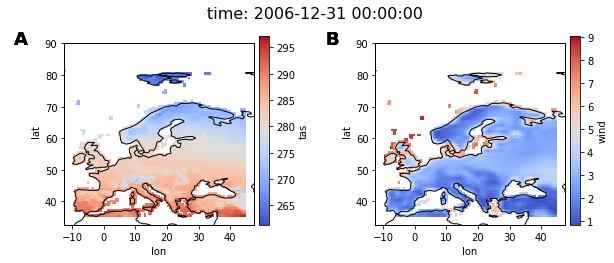
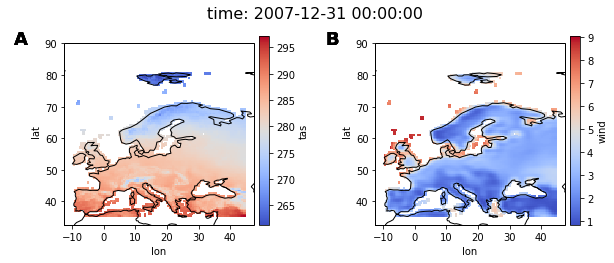
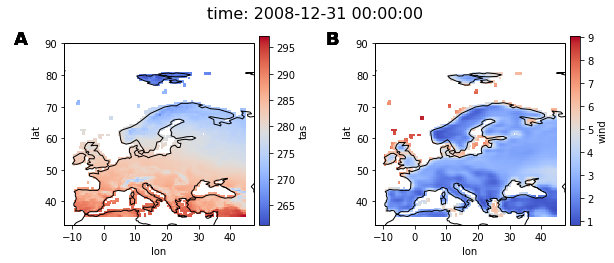
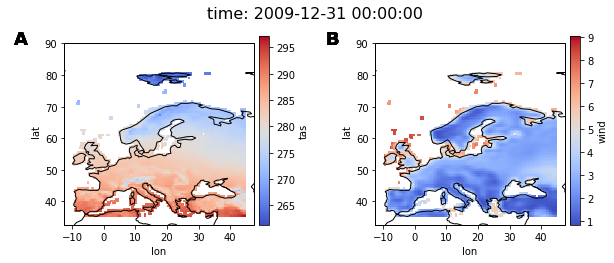
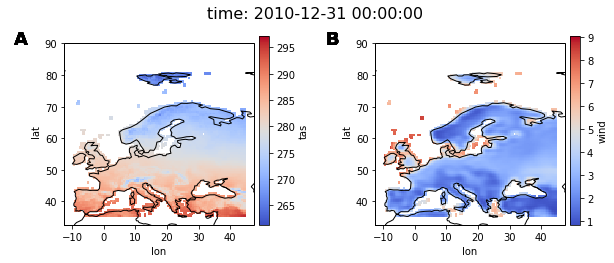

In [5]:
%%opts Image [colorbar=True fig_size=200] (cmap='coolwarm')

# Convert to GeoViews dataset
gv_ds = gv.Dataset(ds2, kdims=['lon', 'lat', 'time'], crs=ccrs.PlateCarree())

# Interactive map
(gv_ds.to(gv.Image, ['lon', 'lat'], ['tas'], ['time'])*gf.coastline() +
 gv_ds.to(gv.Image, ['lon', 'lat'], ['wind'], ['time'])*gf.coastline())

This all looks reasonable: warmer in the south, colder in the north, and windy in Scotland ;-)

For now, I'll assume all the .nc files are structured in exactly the same way and I'll attempt to calculate the required zonal statistics for all models.

## 3. Zones dataset

### 3.1. Reproject zones

Jess has supplied a shapefile defining biogeographic zones, for which she would like to calculate climate statistics. The shapefile uses an ETRS89-based Lambert Azimuthal Equal Area projection, which needs converting to WGS84 geographic co-ordinates in order to be compatible with the climate datasets. The code below creates a new shapefile with the correct projection.

In [6]:
# Read shapefile
shp_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
            r'\Jess_R_Climate_Processing\GIS\Vector\BiogeoRegions2016.shp')
gdf = gpd.read_file(shp_path)

# Reproject to WGS84
gdf = gdf.to_crs({'init':'epsg:4326'})

# Save a new shapefile
shp_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
            r'\Jess_R_Climate_Processing\GIS\Vector\BiogeoRegions2016_WGS84.shp')
gdf.to_file(shp_path, driver='ESRI Shapefile')

gdf

INFO:Fiona:Failed to auto identify EPSG: 7


,PK_UID,short_name,pre_2012,code,name,geometry
0,1,alpine,ALP,Alpine,Alpine Bio-geographical Region,(POLYGON ((13.95511442519602 42.15848966405175...
1,2,anatolian,ANA,Anatolian,Anatolian Bio-geographical Region,"POLYGON ((44.23501132234631 41.00344832599665,..."
2,3,arctic,ARC,Arctic,Arctic Bio-geographical Region,(POLYGON ((-14.15530838424436 64.5954705914306...
3,4,atlantic,ATL,Atlantic,Atlantic Bio-geographical Region,"(POLYGON ((-7.9132686631736 51.90729714870587,..."
4,5,blackSea,BLS,BlackSea,Black Sea Bio-geographical Region,(POLYGON ((31.68170917863957 41.40784270269413...
5,6,boreal,BOR,Boreal,Boreal Bio-geographical Region,(POLYGON ((15.96006489240682 56.17099424674501...
6,7,continental,CON,Continental,Continental Bio-geographical Region,(POLYGON ((11.68926320378824 54.66393862344331...
7,8,macaronesia,MAC,Macaronesia,Macaronesian Bio-geographical Region,(POLYGON ((-15.36375276729933 27.9894042416755...
8,9,mediterranean,MED,Mediterranean,Mediterranean Bio-geographical Region,(POLYGON ((12.52997926244825 35.52716407141582...
9,10,outside,OUT,Outside,outside Europe,"(POLYGON ((10.8358249921599 33.89309066882976,..."


The reprojected shapefile is shown below.

:Polygons   [Longitude,Latitude]   (PK_UID)
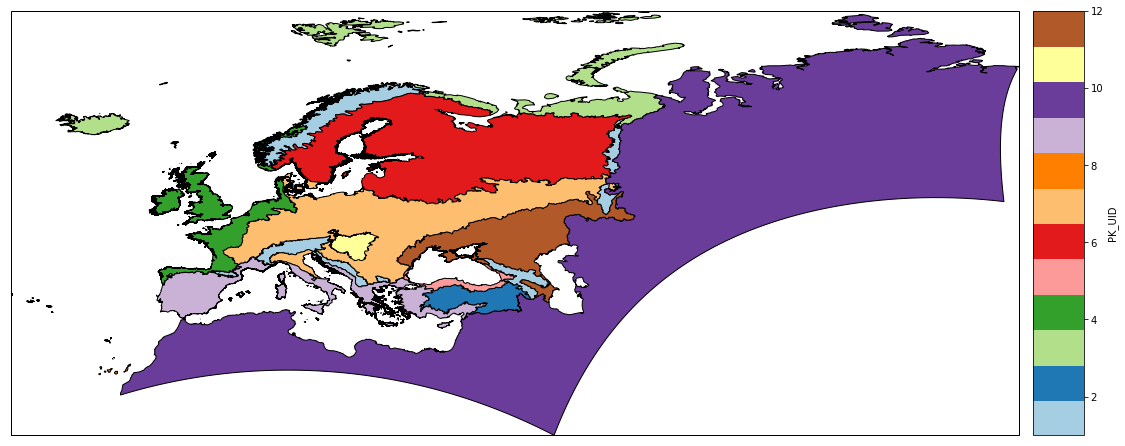

In [7]:
%%opts Polygons [colorbar=True projection=ccrs.PlateCarree() fig_size=500] (cmap='Paired')
gv.Polygons(gdf, vdims='PK_UID')

And the cell below shows the reprojected shapefile ovelaid on the annually averaged climate dataset (from Section 2, above).

:HoloMap   [time]
   :Overlay
      .Image.I    :Image   [lon,lat]   (tas)
      .Polygons.I :Polygons   [Longitude,Latitude]
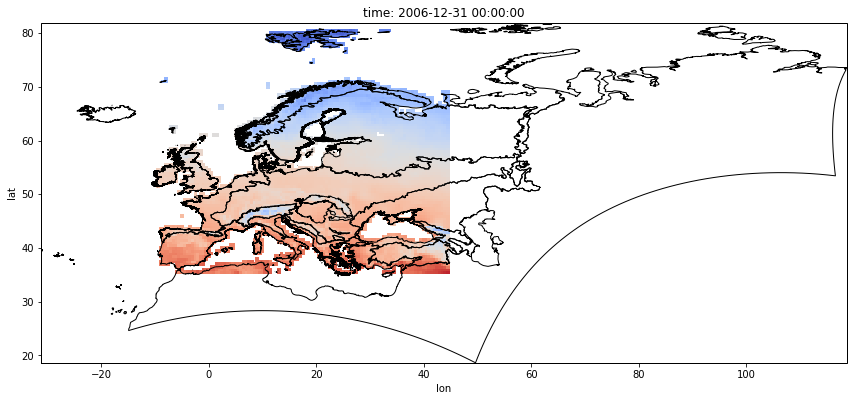
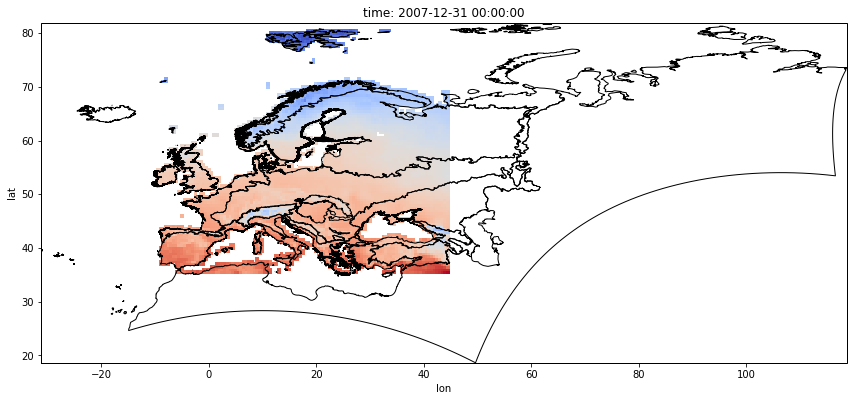
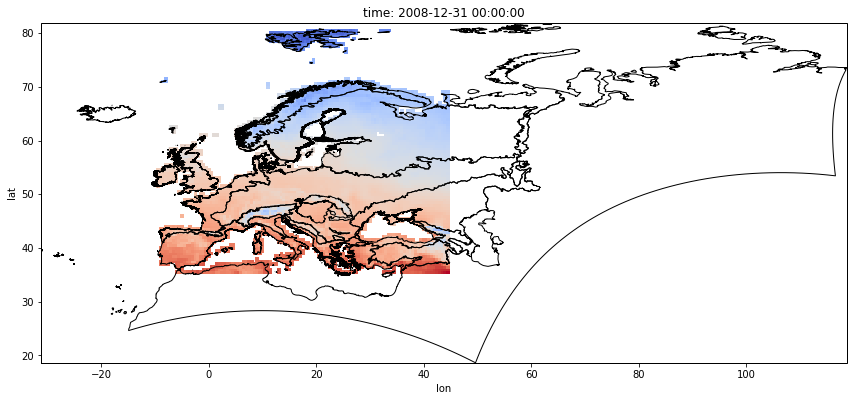
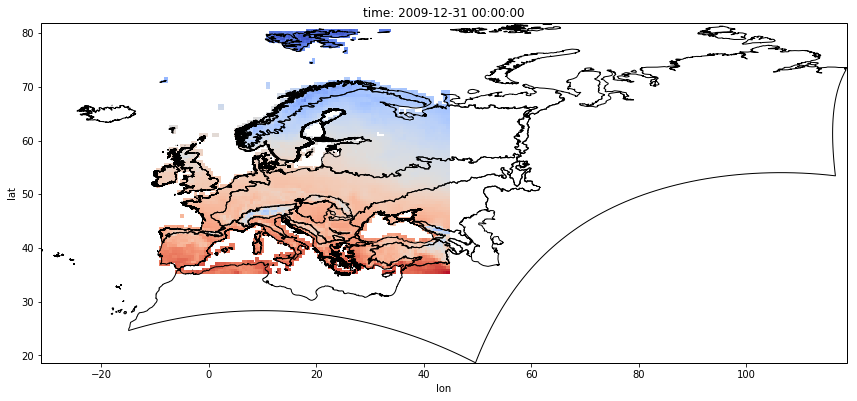
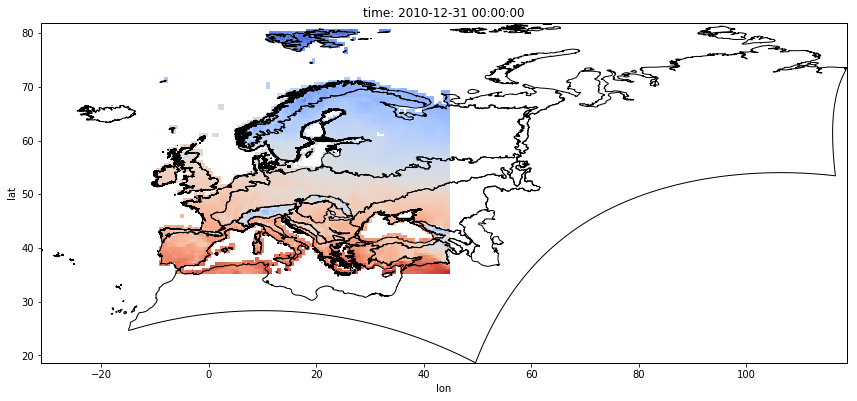

In [8]:
%%opts Image [colorbar=False fig_size=400] (cmap='coolwarm') Polygons (facecolor='none' edgecolor='k')

# Interactive map
gv_ds.to(gv.Image, ['lon', 'lat'], ['tas'], ['time'])*gv.Polygons(gdf)

Although it's good to see that the shapefile aligns correctly with the climate data, it is clear that some of Jess' biogeographical zones are only partially covered by these climate simulations. The **statistics for some zones will therefore be biased**. This issue is worst for **zone 8 ("Macaronesia")**, which is missing completely, and **zone 10 ("Outside Europe")**, which hopefully doesn't matter too much. However, it also affects the **Alpine, Steppic, Continental, Boreal and Arctic zones**. 

### 3.2. Rasterise zones

For calculating summary statistics, the zones shapefile needs converting to a raster with the same cell size and extent as the climate datasets. The easiest way to do this to to generate a single "template" GeoTiff from one of the climate arrays and then use this as a "snap raster" for converting the shapefile.

From Section 2, I know that the grid resolution for the climate data is 0.5 degrees. The next step is to identify the bounding box for the climate arrays.

In [9]:
# Print max and min for lat and lon
print 'Range of lats:', float(ds['lat'].min()), float(ds['lat'].max())
print 'Range of lons:', float(ds['lon'].min()), float(ds['lon'].max())

Range of lats: 35.25 89.75
Range of lons: -9.75 44.75


I will assume that co-ordinates in the climate datasets correspond to grid cell **centres** i.e. the lower-left cell, which has co-ordinates (-9.75, 35.25) is assumed to extend from -10.0 to -9.5 degrees of longitude and from 35.0 to 35.5 degrees of latitude. Based on this and the numbers above, the bounding box for the full dataset is (in WGS84 decimal degrees):

    (xmin, xmax, ymin, ymax) = (-10, 45, 35, 90)
    
The code below creates a GeoTiff snap raster with these dimensions from the average annual climate data for 2006 (calculated above).

In [10]:
# Path for snap tif
snap_tif = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
            r'\Jess_R_Climate_Processing\GIS\Raster\climate_mask.tif')

# Get data array for avg. temp for 2006 as an example
data = ds2.loc[dict(time='2006-12-31')]['tas'].values.copy()

# Proj.4 string for WGS84
prj_str = '+init=epsg:4326'

# Write geotiff
nivapy.spatial.array_to_gtiff(-10, 90, 0.5, snap_tif, data, prj_str)

A quick "sense check" in ArcGIS shows that the newly created GeoTiff aligns with the reprojected shapefile, which is good. The next step is to rasterise the shapefile, using the GeoTiff as a "snap raster".

In [11]:
# Path for zones tif
zone_tif = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
            r'\Jess_R_Climate_Processing\GIS\Raster\biogeo_zones.tif')

# Rasterise
nivapy.spatial.shp_to_ras(shp_path, zone_tif, snap_tif, 'PK_UID', 
                          -1, gdal.GDT_Int16)

The biogeographical zones shapefile is very detailed, but the climate data is rather coarse (0.5 degrees corresponds to a cell size of roughly 55 km by 55 km at the equator). The code below shows the rasterised version of the biogeographical zones. 

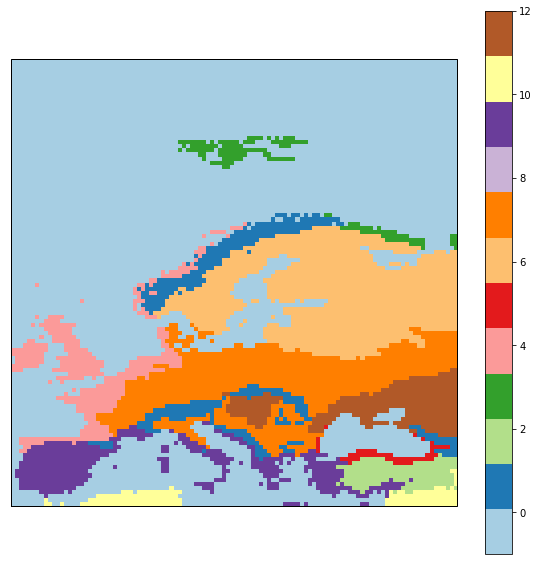

In [12]:
# Read rasterised version
ras_zones, ndv, extent = nivapy.spatial.read_geotiff(zone_tif, flip=True)

# Plot data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Plot array
cax = ax.imshow(ras_zones, 
                zorder=1,
                extent=extent,
                cmap='Paired', 
                alpha=1, 
                interpolation='none')

# Add colourbar
cbar = fig.colorbar(cax)

**Note:** The map legend has an additional category of -1 (coloured light blue), which is used to represent "no data". 

It is obvious that the rasterised version loses a lot of detail compared to the original, but this is necessary to make the zones compatible with the climate data.

## 4. Zonal statistics

The main "number crunching" step involves looping over all the datasets and calculating the desired zonal statistics. However, as the amount of data to be processed is quite large, this may take a long time. Preliminary testing suggests that processing the first 1000 time steps for a single climate model (for two scenarios and two parameters) takes about 8 minutes on my machine, and from the initial data exploration above (see Section 2) I know that the total number of time steps is just over 34000. Processing a single model should therefore take roughly 4.5 hours, which means the total time for all 5 models should be approximately 22 to 23 hours. Fortunately, this workflow is very amenable to parallel processing, so by distributing the calculations for each model to a different CPU, it should be possible to process everything in around 5 hours.

The code below defines a function, `process_clim_model()`, which performs all the zonal statistics calculations for a single climate model. I have then used [ipyparallel](https://github.com/ipython/ipyparallel) to to execute this function on 5 different processors (one for each model). The first step is to use the Jupyter "IPython Clusters" tab to launch an additional 5 Python processes. I can then use ipyparallel to distribute the calculations.

In [13]:
# Get a direct view to the 5 "slave" processors
c = ipp.Client()
view = c[:]

To make the output easier to interpret, I would like to have the names of the biogeographical zones in the results table, instead of just the integer zone IDs. The code below generates a dictionary mapping zone IDs to names, based on the attribute table of the original shapefile. 

**Note:** For simplicity, during the parallel processing this dictionary has been hard-coded into `process_clim_model()`. This approach is a bit lazy, but it should be OK for what's required here. 

In [14]:
# Create dict mapping integer IDs to zone names
gdf.index = gdf['PK_UID']
zone_dict = gdf['code'].to_dict()

zone_dict

{1: u'Alpine',
 2: u'Anatolian',
 3: u'Arctic',
 4: u'Atlantic',
 5: u'BlackSea',
 6: u'Boreal',
 7: u'Continental',
 8: u'Macaronesia',
 9: u'Mediterranean',
 10: u'Outside',
 11: u'Pannonian',
 12: u'Steppic'}

The cell below defines a function for the zonal statistics calculations. The `'%%px --local'` command at the start executes this code on each of the 5 "slave" processes, so that they all have access to the data and modules required later.

In [15]:
%%px --local
def process_clim_model(mod):
    """ Calculate zonal statistics from climate data.
    
        NOTE: This function is not very re-usable, due to 
        hard-coding of paths etc.
    
    Args:
        mod: Str. The name of the model to be processed
        
    Returns:
        Dataframe of zonal statistics for the specified model
    """
    import nivapy
    import pandas as pd
    import xarray as xr
    import os
    import gdal
    import numpy as np

    # Define scenarios, paths and pars
    clim_fold = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
                 r'\Jess_R_Climate_Processing\netCDF')
    zone_tif = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
                r'\Jess_R_Climate_Processing\GIS\Raster\biogeo_zones.tif')
    scens = ['rcp4p5', 'rcp8p5']
    pars = ['tas', 'wind']
    
    # Dict for results
    res_dict = {'Date':[],
                'Model':[],
                'Scen':[],
                'Par':[],
                'Zone':[],
                'Mean':[],
                'Median':[],
                'Min':[],
                'Max':[],
                'StdDev':[]}
    
    # Define dict mapping zone IDs to names
    zone_dict = {1: u'Alpine',
                 2: u'Anatolian',
                 3: u'Arctic',
                 4: u'Atlantic',
                 5: u'BlackSea',
                 6: u'Boreal',
                 7: u'Continental',
                 8: u'Macaronesia',
                 9: u'Mediterranean',
                 10: u'Outside',
                 11: u'Pannonian',
                 12: u'Steppic'}

    # Read rasterised zones
    ras_zones, ndv, extent = nivapy.spatial.read_geotiff(zone_tif)

    # Loop over scenarios
    for scen in scens:
        # Build path to data folder
        nc_path = os.path.join(clim_fold, mod, scen, '*.nc')

        # Read netCDF data
        ds = xr.open_mfdataset(nc_path)

        # Loop over days
        for t_step in ds['time']:
            # Get data
            dt = t_step.data

            # Loop over pars
            for par in pars:
                # Get arrays
                data = ds.loc[dict(time=t_step)][par].values

                # Loop over zones
                for zn in zone_dict.keys():
                    # Mask values not in this zone or NaN
                    # Temp
                    masked = np.ma.MaskedArray(data, 
                                               mask=np.logical_or(ras_zones!=zn,
                                                                  np.isnan(data)))

                    # Calculate stats and add to output
                    res_dict['Date'].append(dt)
                    res_dict['Model'].append(mod)
                    res_dict['Scen'].append(scen)
                    res_dict['Par'].append(par)
                    res_dict['Zone'].append(zone_dict[zn])
                    res_dict['Mean'].append(masked.mean())
                    res_dict['Median'].append(np.ma.median(masked))
                    res_dict['Min'].append(masked.min())
                    res_dict['Max'].append(masked.max())
                    res_dict['StdDev'].append(masked.std())

    # Build results dataframe
    df = pd.DataFrame(res_dict)
    df = df[['Date', 'Model', 'Scen', 'Par', 'Zone', 
             'Mean', 'Median', 'Min', 'Max', 'StdDev']]

    # Values for Macaronesia are all always "masked" (see S3.1)
    # This is not supported by SQLite, so convert to NaN
    for stat in ['Mean', 'Median', 'Min', 'Max', 'StdDev']:
        df[stat] = df[stat].astype(float)
        
    return df

The final step for the zonal statistics is to map the processing for each model to a different CPU. This is done by the code below.

In [16]:
%%time
# Define models fo interest
models = ['GFDL-ESM2M', 'HadGEM2-ES', 'MIROC-ESM-CHEM', 
          'NorESM1-M', 'IPSL-CM5A-LR']

# Run parallel calculations
res = view.map_sync(process_clim_model, models)

# Concatenate to single dataset
df = pd.concat(res, axis=0)

Wall time: 6h 1min 4s


In [17]:
# Show first results for each zone
df.head(12)

,Date,Model,Scen,Par,Zone,Mean,Median,Min,Max,StdDev
0,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Alpine,266.540612,267.686707,253.852631,281.809845,6.010394
1,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Anatolian,274.015822,274.962402,264.143280,282.276886,4.150497
2,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Arctic,256.143071,256.088562,245.990997,268.096924,6.117394
3,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Atlantic,277.120486,277.179810,262.707031,286.874756,3.823635
4,2006-01-01,GFDL-ESM2M,rcp4p5,tas,BlackSea,275.675347,275.857590,265.681244,284.601379,3.639692
5,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Boreal,268.749469,269.649490,256.910583,275.949371,4.224316
6,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Continental,273.269737,273.164307,268.392517,281.564514,2.164652
7,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Macaronesia,NaN,NaN,NaN,NaN,NaN
8,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Mediterranean,280.683626,280.611313,272.773254,287.057159,2.886702
9,2006-01-01,GFDL-ESM2M,rcp4p5,tas,Outside,282.366902,282.832672,269.134827,286.815796,2.919404


## 5. Save results

[SQLite](https://www.sqlite.org/) is a powerful, portable, relational database that is well-suited to storing (and restructuring) these kinds of results. For simplicity, I'll also save the results dataset as a CSV.

### 5.1. To SQLite

In [18]:
# Create database and connect
db_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
           r'\Jess_R_Climate_Processing\Results\mars_biogeo_climate_stats.db')
con = sqlite3.connect(db_path)

# SQLite doesn't like datetime64 objects, so convert to "normal" dates
df['Date'] = pd.DatetimeIndex(df['Date']).date

# Write to db
df.to_sql('clim_stats', con=con, index=False, if_exists='replace')
con.close()

### 5.2. To CSV

In [19]:
# Save to CSV
csv_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
            r'\Jess_R_Climate_Processing\Results\mars_biogeo_climate_stats.csv')
df.to_csv(csv_path, index=False)

## 6. Data checking

As a quick check that thre results looks sensible, the code below calculates **annual mean temperature** for each zone and for each model and scenario.

In [4]:
# Connect to db
db_path = (r'C:\Data\James_Work\Staff\Jannicke_M\MARS'
           r'\Jess_R_Climate_Processing\Results\mars_biogeo_climate_stats.db')
con = sqlite3.connect(db_path)

# Query database
sql = ("SELECT CAST(strftime('%Y', Date) AS INT) as Year, "
       "  Model, "
       "  Scen, "
       "  Par, "
       "  Zone, "
       "  AVG(Mean) AS Mean "
       "FROM clim_stats "
       "WHERE Par = 'tas' "
       "GROUP BY Year, Model, Scen, Par, Zone")

df = pd.read_sql(sql, con)

df.head()

,Year,Model,Scen,Par,Zone,Mean
0,2005,HadGEM2-ES,rcp4p5,tas,Alpine,276.335740
1,2005,HadGEM2-ES,rcp4p5,tas,Anatolian,283.516629
2,2005,HadGEM2-ES,rcp4p5,tas,Arctic,267.987334
3,2005,HadGEM2-ES,rcp4p5,tas,Atlantic,283.211010
4,2005,HadGEM2-ES,rcp4p5,tas,BlackSea,283.207373


And the code below creates a "factor plot" showing changes in annual temperature from 2006 to 2099.

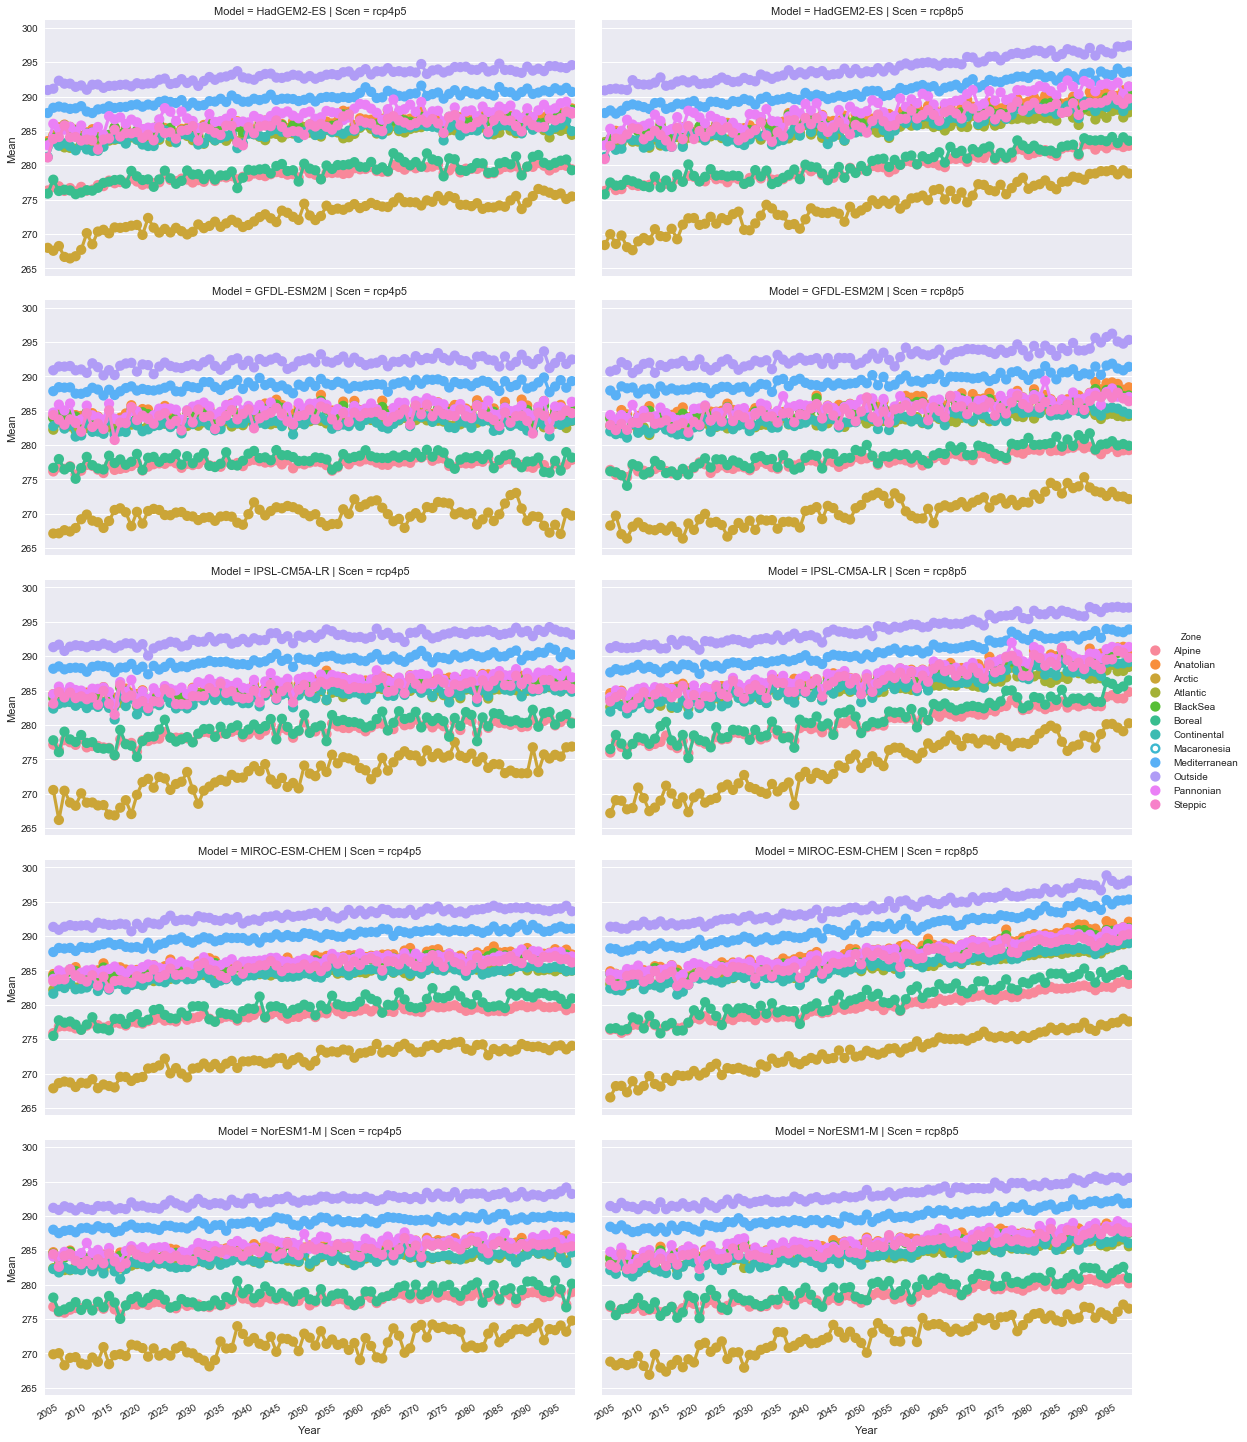

In [7]:
# Factorplot
g = sn.factorplot(data=df, x='Year', y='Mean', hue='Zone',
                  row='Model', col='Scen', height=8, aspect=2)

# Tidy xlabels
ax = plt.gca()
g.set_xticklabels(rotation=30)
g.set(xticks=ax.get_xticks()[::5], xticklabels=ax.get_xticklabels()[::5])

This looks OK, in the sense that the Arctic is always the coldest, the Mediterranean and "Outside Europe" are always the warmest, and the temperatures steadily increase over time.